In [19]:
import os


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view   
import optuna

In [62]:
from one.generator.univariate import UnivariateDataGenerator
from one.models import *
from one.utils import *
from one.scorer.pot import *
from one.scorer.spot import *
import jenkspy

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
plt.rcParams["figure.figsize"] = 40,10
plt.rcParams["font.size"] = 15

# Scoring Helper

In [12]:
class ScoreCounter:
    def __init__(self):
        self.tp = 0
        self.fp = 0
        self.tn = 0
        self.fn = 0
        
    def process(self, preds, labels):
        preds = preds.copy()
        labels = labels.copy()
        ground_truth_ones = np.where(labels == 1)[0]
        pred_ones = np.where(preds == 1)[0]
        
        ranges = self._consecutive(ground_truth_ones)
        
        tp, fp, tn, fn = 0, 0, 0, 0
        
        for r in ranges:
            intersect = np.intersect1d(r, pred_ones, assume_unique=True)
            if intersect.size != 0:
                tp += r.size
                preds[intersect] = 0
                pred_ones = np.where(preds == 1)[0]
            else:
                fn += r.size
            
        fp += pred_ones.size
        tn += preds.size - tp - fp - fn
        
        self.tp += tp
        self.fp += fp
        self.tn += tn
        self.fn += fn
        
        
        return
        
        
    def _consecutive(self, data, stepsize=1):
        return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
    
    
    @property
    def tpr(self):
        return self.tp/(self.fn+self.tp)
    
    @property
    def fpr(self):
        return self.fp/(self.tn+self.fp)
    
    @property
    def tnr(self):
        return self.tn/(self.tn+self.fp)
        
    @property
    def fnr(self):
        return self.fn/(self.fn+self.tp)
        
    @property
    def precision(self):
        return self.tp/(self.tp+self.fp)
    
    @property
    def recall(self):
        return self.tp/(self.tp+self.fn)
    
    @property
    def f1(self):
        if self.precision + self.recall == 0: return 0
        return (2*self.precision*self.recall)/(self.precision+self.recall)
    
    

# Run Experiments

## F1 Tuned - 50% dataset

### -- Setup

In [21]:
from one.models import *
from one.utils import *
from one.scorer.pot import *
from numpy.lib.stride_tricks import sliding_window_view   

In [22]:
PATH0 = "../data/univar-synth/point_global/"
PATH1 = "../data/univar-synth/point_contextual/"
PATH2 = "../data/univar-synth/collective_global/"
PATH3 = "../data/univar-synth/collective_trend/"
PATH4 = "../data/univar-synth/collective_seasonal/"

In [23]:
PATHS = [PATH0, PATH1, PATH2, PATH3, PATH4]

In [26]:
SAVE_DIR = "../results/univar-synth/thresholding/"

In [25]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

### MA

#### Quantile

In [220]:
# MA Model 
import warnings
warnings.filterwarnings('ignore')

thres_method = "spot"

for path in PATHS:
    file_list = ["-".join(f.split("-")[:-1]) for f in get_files_from_path(path) if "train" in f]
    scorer = ScoreCounter()
    for f in file_list:
        train = np.loadtxt(path+f+"-train.txt")
        test = np.loadtxt(path+f+"-test.txt")
        labels = np.loadtxt(path+f+"-labels.txt")

        n_tune = labels.size // 2
        tune_data, tune_labels = test[:n_tune], labels[:n_tune]
        test_data, test_labels = test[n_tune:], labels[n_tune:]
        
        def objective(trial):
            s = ScoreCounter()
            window = 50
            
            contam = trial.suggest_float("contam", 0.90, 0.999)
            q = trial.suggest_float("q", 1e-5, 1e-1, log=True)
            nb_class = trial.suggest_int("nb_class", 2, 30)
            
           
            test_extend = np.concatenate((train[-window:], tune_data))
            model = MovingAverageModel(window)
            scores = np.abs(model.get_scores(test_extend)[window:])
            
            #get threshold
            # thres = np.quantile(scores, contam) # quantile
            # thres = pot(scores, q, contam) # pot
            # thres = jenkspy.jenks_breaks(scores, nb_class=nb_class)[-2] # jenks
            
            spot = SPOT(q, contam) 
            thres = spot.load_initial(scores[:100]) # spot
            thres = spot.step_all(scores[100:]) # spot
            
            
            preds = scores[100:].copy() # spot
            # preds = scores.copy()
            preds[preds <= thres] = 0
            preds[preds > thres] = 1
 
            s.process(preds, tune_labels)
        
            if s.tp == 0 and s.fp == 0: return -1
            if s.tp == 0 and s.fn == 0: return -1

            if s.precision == 0 and s.recall == 0: return -1
            return s.f1
            
       
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50)
       
        window = 50
        contam = study.best_params["contam"]
        q = study.best_params["q"]
        nb_class = study.best_params["nb_class"]
        model = MovingAverageModel(window)
        
        test_extend = np.concatenate((train[-window:], test))
        
        scores = model.get_scores(test_extend)[0]
        
        #get threshold
        # thres = np.quantile(scores[:n_tune], contam) # quantile
        # thres = pot(scores[:n_tune], q, contam) # pot
        # thres = jenkspy.jenks_breaks(scores[:n_tune], nb_class=nb_class)[-2] # jenks

        spot = SPOT(q, contam)
        spot.load_initial(scores[:100]) # spot
        thres = spot.step_all(scores[100:])[n_tune-100:] # spot

        preds = scores[n_tune:].copy()
        preds[preds <= thres] = 0
        preds[preds > thres] = 1

        scorer.process(preds, labels[n_tune:])
        
        # Save results
        save = SAVE_DIR+f"ma/{thres_method}/"+f
        os.makedirs(SAVE_DIR+f"ma/{thres_method}", exist_ok=True)
        params = study.best_params
        params.update({"thres": thres})
        np.savetxt(save+"-scores.txt", scores[n_tune:], header=str(params))
        np.savetxt(save+"-preds.txt", preds, header=str(params))


    print(f"{scorer.tp}, {scorer.fp}, {scorer.tn}, {scorer.fn}, {scorer.tpr}, {scorer.fpr}, {scorer.tnr}, {scorer.fnr}, {scorer.precision}, {scorer.recall}, {scorer.f1}")

123, 85, 9425, 367, 0.2510204081632653, 0.008937960042060988, 0.991062039957939, 0.7489795918367347, 0.5913461538461539, 0.2510204081632653, 0.35243553008595985
32, 264, 9262, 442, 0.06751054852320675, 0.02771362586605081, 0.9722863741339491, 0.9324894514767933, 0.10810810810810811, 0.06751054852320675, 0.0831168831168831
100, 4, 9496, 400, 0.2, 0.0004210526315789474, 0.999578947368421, 0.8, 0.9615384615384616, 0.2, 0.3311258278145695
200, 14, 9786, 0, 1.0, 0.0014285714285714286, 0.9985714285714286, 0.0, 0.9345794392523364, 1.0, 0.966183574879227
467, 91, 9142, 300, 0.6088657105606258, 0.009855951478392721, 0.9901440485216073, 0.39113428943937417, 0.8369175627240143, 0.6088657105606258, 0.7049056603773585


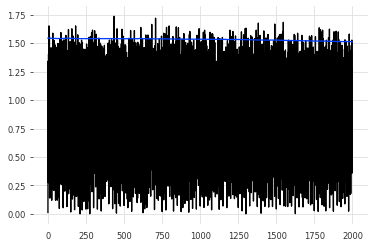

In [218]:
plt.plot(scores[2000:])
plt.plot(thres)

## Load Results

In [ ]:
SAVE_DIR = "../results/univar-synth/thresholding/"
model = "quantile"
thres_method = "quantile"
for path in PATHS:
    scorer = ScoreCounter()
    file_list = ["-".join(f.split("-")[:-1]) for f in get_files_from_path(path) if "train" in f]
    for f in file_list:
        preds = np.loadtxt(SAVE_DIR+f"{model}/"+f+"-preds.txt")
        labels = np.loadtxt(path+f+"-labels.txt")[-len(preds):]
        if len(preds) != 2000: break
        scorer.process(preds, labels)
        
    print(f"{scorer.tp}, {scorer.fp}, {scorer.tn}, {scorer.fn}, {scorer.tpr}, {scorer.fpr}, {scorer.tnr}, {scorer.fnr}, {scorer.precision}, {scorer.recall}, {scorer.f1}")

165, 23, 9487, 325, 0.336734693877551, 0.00241850683491062, 0.9975814931650894, 0.6632653061224489, 0.8776595744680851, 0.336734693877551, 0.48672566371681414
19, 203, 9323, 455, 0.04008438818565401, 0.02131009867730422, 0.9786899013226957, 0.959915611814346, 0.08558558558558559, 0.04008438818565401, 0.0545977011494253
200, 194, 9306, 300, 0.4, 0.020421052631578947, 0.9795789473684211, 0.6, 0.5076142131979695, 0.4, 0.44742729306487694
100, 271, 9529, 100, 0.5, 0.027653061224489794, 0.9723469387755102, 0.5, 0.2695417789757412, 0.5, 0.350262697022767
667, 197, 9036, 100, 0.8696219035202086, 0.021336510343333694, 0.9786634896566663, 0.1303780964797914, 0.7719907407407407, 0.8696219035202086, 0.8179031269160024
